In [1]:
import numpy as np
from numpy.random import normal
from scipy.linalg import cholesky
import matplotlib.pyplot as plt

np.random.seed(101)

## Exercise 5.2: Sampling from a Gaussian Process ##

In this exercise we will learn how to sample from a Gaussian process. For this we will re-visit the example given in the lecture slides 23 - 25 of the lecture *Bayesian Linear Regression and Gaussian Pocesses*.

It's mainly meant for illustration, and only has a few tasks. We hope it will make the concept of a Gaussian process easier to understand! 

The output of a Gaussian process follows a multi-variate Gaussian distribution. As such, we can describe this distribution with a vector of mean values $\mathbf{\mu}$ and a covariance matrix $\mathbf{\Sigma}$:

$$ \mathbf{y} \sim \mathcal{N}(\mu,\Sigma)$$

For this example, we will assume that $\mu$ is a vector of zeros, and we will construct a covariance matrix using a specific recipe, which will then define our Gaussian process. We will go through this recipe step by step.

We want to produce a series of values $\mathbf{y}$, corresponding to points $\mathbf{x}$, such that neighboring values (i.e. $\mathbf{y}_i$ and $\mathbf{y}_{i+1}$) are correlated with each other. Further we want this correlation to decrease the further apart the points $\mathbf{x}$ are.

We initialize a vector `x` of linearly spaced values, each defining a single point, which we will use to construct our covariance matrix:

In [2]:
x = np.linspace(-50,50,num=100,endpoint=True) # 100 values from -50 to 50

We can use a kernel function on this vector in order to construct a kernel matrix $\mathbf{K}$, which we will use as our covariance matrix.

The kernel function we will use is the *squared exponential* kernel, $k_{SE}$, which is defined as follows:

$$k_{SE}(x_i,x_j,A,L) = A^2 exp(-0.5 \frac{(x_i-x_j)^2}{L^2})$$

The kernel matrix is then constructed as:

$$K_{i,j}=k_{SE}(x_i, x_j)$$

where $A$ and $L$ are hyper-parameters.

## Task 1: ##  
Implement a function that will construct the covariance matrix $\mathbf{K}$ ($\mathbf{\Sigma}$) for a given vector of linearly spaced values `x` and hyper-parameters, `A` and `L`.



In [3]:
# Task 1: We construct a covariance matrix K that defines our Gaussian process
def k_sqexp(x, A, L):
    k_SE = lambda xi, xj: A**2 * np.exp(-0.5 * ((xi - xj) ** 2) / L ** 2)
    # your_code (use either a nested loop or nested list comprehension to contstruct K)
    K = [[k_SE(xi, xj) for xj in x] for xi in x]   
    # we add a small offset to the diagnonal for numerical stability later
    K = K + np.eye(len(x))*1e-7
    
    return K

In [4]:
# we calculate three different kernel matrices K 
K1, K2, K3 = k_sqexp(x, 1., 10.), k_sqexp(x, 1., 5.), k_sqexp(x, 1., 2.5)

In [5]:
print('K1[0,0]: {:.4f}'.format(K1[0,0]))
print('K1[3,2]: {:.4f}'.format(K1[3,2]))
print('K1[10,2]: {:.4f}'.format(K1[10,2]))

K1[0,0]: 1.0000
K1[3,2]: 0.9949
K1[10,2]: 0.7214


**Expected Output:**   
K1[0,0]: 1.0000  
K1[3,2]: 0.9949  
K1[10,2]: 0.7214


We now plot the covariance matrices we have produced above, which use different values of $L$ (10, 5, and 2.5), while keeping A constant (1). Make sure you understand the resulting patterns. You can play around with other values for A and L later!

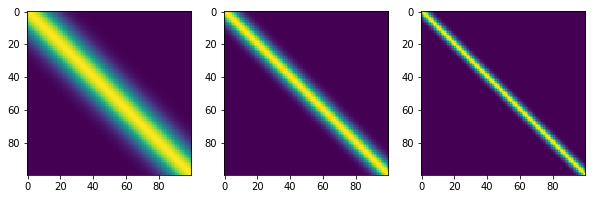

In [6]:
fig, ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(K1)
ax[1].imshow(K2)
ax[2].imshow(K3)

We have now defined three covariance matrices K. We can sample from the corresponding Gaussian processes in the following way:

1. draw a sample of $N$ independent Gaussian variables $\tilde{y}$ from the distribution $\mathcal{N}(0,1)$

2. Rotate with $\sqrt{\mathbf{K}}$, i.e. calculate:  
$y = \tilde{y} {\mathbf{L}}$

where $\mathbf{L}$ is the lower triangular Cholesky matrix $\mathbf{L}\mathbf{L}^* = \mathbf{K}$.  
where $\mathbf{L}^*$ is the conjugate transpose of $\mathbf{L}$.

We will visualize this for one example.

## Task 2: ##

Sample a set of `len(x)` independent variables from the distribution $\mathcal{N}(0,1)$ (tip: use `normal()`), store the values in `y_tilde`. Calculate the corresponding cholesky matrices for the kernel matrices `K1`, `K2`, `K3` with the `cholesky()` function (already imported above), which will give you chol1, chol2 and chol3 respectively. Rotate `y_tilde` with the different cholesky matrices, which will yield `y1`, `y2` and `y3` respectively:

In [7]:
y_tilde = normal(size=len(x))

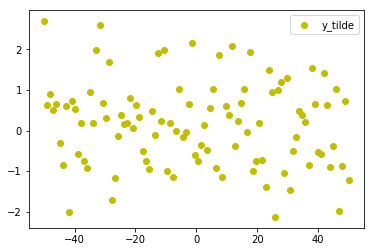

In [8]:
plt.scatter(x, y_tilde, color='y', label='y_tilde')
plt.legend()

In [9]:
# calculate cholesky matrices for K1, K2, K3:
chol1, chol2, chol3 = (cholesky(K1), cholesky(K2), cholesky(K3))

# "rotate" y_tilde with chol1, chol2 and col3: 
y1, y2, y3 = (y_tilde.dot(chol1), y_tilde.dot(chol2), y_tilde.dot(chol3))

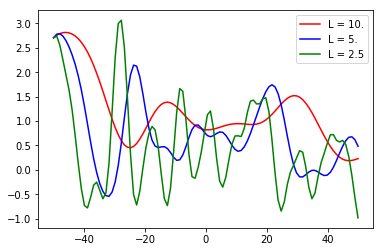

In [10]:
plt.plot(x, y1, color='r', label='L = 10.')
plt.plot(x, y2, color='b', label='L = 5.')
plt.plot(x, y3, color='g', label='L = 2.5')
plt.legend()
# pretty!

In [11]:
print('y1[51]: {:.3f}'.format(y1[51]))
print('y2[42]: {:.3f}'.format(y2[42]))
print('y3[10]: {:.3f}'.format(y3[10]))

y1[51]: 0.823
y2[42]: 0.304
y3[10]: -0.728


** Expected Output (might be different if you played around a lot, re-start and run again to make sure you did the right thing) **:  
y1[51]: 0.823  
y2[42]: 0.304  
y3[10]: -0.728  


Finally, we want to visualize how the points that are near each other covary for different samples generated by the Gaussian process.

For this, write a function that takes a kernel matrix `K` and an integer `t`, and returns a (`t` by `M`) matrix, where `M` is the number of columns/rows in the kernel matrix and every row corresponds to a sample drawn from the Gaussian process defined by `K`.

In [12]:
# write a function that samples from our Gaussian process t-times, and returns a matrix S

def sample_gauss(K,n):
    
    # your_code
    S = K[np.random.randint(0, len(K), n)]
    return S


In [13]:
Y = sample_gauss(K1, 150)

In [14]:
print('Y.shape: {}'.format(Y.shape))

Y.shape: (150, 100)


** Expected Output:**   
Y.shape: (150, 100)


Finally, we pick two points (columns of `Y`), and plot them against each other across samples (all the rows).

Repeat the plot below for different pairs of points. What do we observe when we pick points that are close to each other (i.e. 10 and 12), vs when we pick points that are far away? 

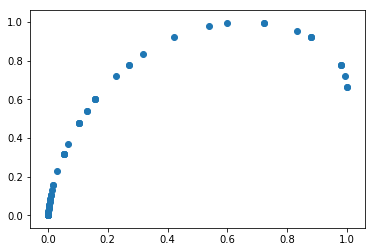

In [15]:
plt.scatter(Y[:,1], Y[:,10])

Congratulations, you made it through the sixth tutorial of this course!

# Submitting your assignment

Please rename your notebook under your full name and **submit it on the moodle platform**.

Please rename the file to 6_Gaussian_Processes_Sampling_<GROUP\>.ipynb and replace <GROUP\> with your group-name.

As this is also the first time for us preparing this tutorial, you are welcome to give us feedback to help us improve this tutorial.  

Thank you!  

Jana & Remo